In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 94% 57.0M/60.3M [00:02<00:00, 35.9MB/s]
100% 60.3M/60.3M [00:02<00:00, 24.6MB/s]


In [ ]:
!unzip fer2013.zip -d ferplus

Streaming output truncated to the last 5000 lines.
  inflating: ferplus/train/sad/Training_65242339.jpg  
  inflating: ferplus/train/sad/Training_65267116.jpg  
  inflating: ferplus/train/sad/Training_65275626.jpg  
  inflating: ferplus/train/sad/Training_6529266.jpg  
  inflating: ferplus/train/sad/Training_65329617.jpg  
  inflating: ferplus/train/sad/Training_65338712.jpg  
  inflating: ferplus/train/sad/Training_65338797.jpg  
  inflating: ferplus/train/sad/Training_65387162.jpg  
  inflating: ferplus/train/sad/Training_65404494.jpg  
  inflating: ferplus/train/sad/Training_65426218.jpg  
  inflating: ferplus/train/sad/Training_65430136.jpg  
  inflating: ferplus/train/sad/Training_65437377.jpg  
  inflating: ferplus/train/sad/Training_6545735.jpg  
  inflating: ferplus/train/sad/Training_65463385.jpg  
  inflating: ferplus/train/sad/Training_65473985.jpg  
  inflating: ferplus/train/sad/Training_65502829.jpg  
  inflating: ferplus/train/sad/Training_65505359.jpg  
  inflating: fer

In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split

# Define transformations for training and testing datasets
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the full training dataset
full_train_dataset = datasets.ImageFolder(root='ferplus/train', transform=train_transform)

# Split the training dataset into training and validation datasets
total_size = len(full_train_dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size  # Remaining size for validation

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Load the test dataset
test_dataset = datasets.ImageFolder(root='ferplus/test', transform=test_transform)

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


In [ ]:
import torch
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Load the pre-trained DenseNet model
model = models.densenet121(pretrained=True)

# Modify the last fully connected layer to match the number of emotion classes
num_ftrs = model.classifier.in_features
model.classifier = torch.nn.Linear(num_ftrs, len(train_dataset.dataset.classes))  # len(train_dataset.dataset.classes) should be 7 or 8 based on your classes

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define learning rate scheduler
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 103MB/s]


In [ ]:
# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Training step
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Adjust learning rate
    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")

    # Validation step
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f"Validation Loss: {val_loss/len(val_loader)}, Accuracy: {val_accuracy}%")

Epoch [1/10], Loss: 1.5154717604429941
Validation Loss: 1.386126317580541, Accuracy: 46.86520376175549%
Epoch [2/10], Loss: 1.2943398312439827
Validation Loss: 1.2953181448909972, Accuracy: 50.88819226750261%
Epoch [3/10], Loss: 1.2187576311378425
Validation Loss: 1.1667634550068113, Accuracy: 56.1128526645768%
Epoch [4/10], Loss: 1.1659931716480627
Validation Loss: 1.1809043559763166, Accuracy: 55.172413793103445%
Epoch [5/10], Loss: 1.1358820261397402
Validation Loss: 1.1097569412655302, Accuracy: 57.088122605363985%
Epoch [6/10], Loss: 1.0967348311770926
Validation Loss: 1.1853823062446383, Accuracy: 55.607802159526294%
Epoch [7/10], Loss: 1.0753189977829172
Validation Loss: 1.0742060997419887, Accuracy: 59.82236154649948%
Epoch [8/10], Loss: 0.9617203594416297
Validation Loss: 0.9721209933360417, Accuracy: 62.765586903517935%
Epoch [9/10], Loss: 0.9214378672555961
Validation Loss: 0.9705038747853703, Accuracy: 62.9745733194009%
Epoch [10/10], Loss: 0.8995521355804295
Validation Los

In [ ]:
torch.save(model.state_dict(), 'densenet_emotion_model_with_da.pth')


In [21]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms

# Recreate the model architecture
model = models.densenet121(pretrained=True)

# Modify the last fully connected layer to match the number of emotion classes
num_ftrs = model.classifier.in_features
model.classifier = torch.nn.Linear(num_ftrs, len(train_dataset.dataset.classes))

# Load the saved state dict
model.load_state_dict(torch.load('densenet_emotion_model_with_da.pth'))

# Set the model to evaluation mode
model.eval()


<ipython-input-21-732498d46652>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('densenet_emotion_model_with_da.pth'))


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
def calculate_accuracy(model, test_loader, device):
    model.eval()  # Ensure the model is in evaluation mode
    correct = 0
    total = 0

    # Disable gradient calculation (not needed for inference)
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(images)

            # Get the predicted class with the highest score
            _, predicted = torch.max(outputs.data, 1)

            # Update total number of labels and correct predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate accuracy
    accuracy = correct / total * 100
    return accuracy


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # Move model to the appropriate device


In [23]:
# Assuming 'test_loader' is already defined and contains the test dataset
calculate_accuracy(model, test_loader, device)



64.1404290888827

In [ ]:
def detect_faces_and_emotions(image, model, device):
    # Convert the image to grayscale for face detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image

# Load the pre-trained face detection model
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Transform the face images to the required format
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    model.to(device)

    predictions = []

    for (x, y, w, h) in faces:
        # Crop the face from the image
        face = image[y:y+h, x:x+w]

        # Apply the transform to the face
        face_tensor = transform(face).unsqueeze(0).to(device)

        # Predict the emotion
        with torch.no_grad():
            output = model(face_tensor)
            _, predicted = torch.max(output, 1)
            predictions.append((predicted.item(), (x, y, w, h)))

    return predictions


In [ ]:
def draw_boxes_and_labels(image, predictions, class_names):
    for (emotion, (x, y, w, h)) in predictions:
        # Draw the rectangle around the face
        cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)

        # Get the emotion label
        label = class_names[emotion]

        # Increase font scale and thickness for larger text
        font_scale = 1.5  # Increased font scale
        thickness = 3     # Increased thickness

        # Put the label text above the rectangle with larger font
        cv2.putText(image, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (36, 255, 12), thickness)

    return image


In [30]:
!wget https://img.freepik.com/premium-photo/3d-rendered-illustration-angry-man-face_181203-19311.jpg

--2024-09-20 13:23:56--  https://img.freepik.com/premium-photo/3d-rendered-illustration-angry-man-face_181203-19311.jpg
Resolving img.freepik.com (img.freepik.com)... 96.16.53.162, 96.16.53.137, 2a02:26f0:1180:19::212:7905, ...
Connecting to img.freepik.com (img.freepik.com)|96.16.53.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66714 (65K) [image/jpeg]
Saving to: ‘3d-rendered-illustration-angry-man-face_181203-19311.jpg’

3d-rendered-illustr 100%[===================>]  65.15K  --.-KB/s    in 0.05s   

2024-09-20 13:23:56 (1.24 MB/s) - ‘3d-rendered-illustration-angry-man-face_181203-19311.jpg’ saved [66714/66714]



In [31]:
import cv2
from torchvision import transforms
import matplotlib.pyplot as plt

# Load the test image
image_path = '/content/3d-rendered-illustration-angry-man-face_181203-19311.jpg'
image = cv2.imread(image_path)

# Convert the image to RGB (OpenCV loads images in BGR by default)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


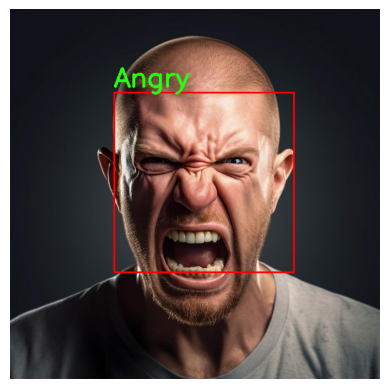

In [32]:
# Get the emotion predictions
predictions = detect_faces_and_emotions(image_rgb, model, device)

# Draw the bounding boxes and labels on the image
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
image_with_annotations = draw_boxes_and_labels(image_rgb, predictions, class_names)

# Display the image
plt.imshow(image_with_annotations)
plt.axis('off')
plt.show()


In [25]:
import cv2
import torch
import torchvision.transforms as transforms
from google.colab import files
from IPython.display import HTML
import base64

# Upload video file
uploaded = files.upload()

# Load the uploaded video file
video_path = next(iter(uploaded.keys()))
cap = cv2.VideoCapture(video_path)

# Load your trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

# Initialize face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Define preprocessing transformations
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Class names
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Define output video parameters
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output_video.mp4', fourcc, cap.get(cv2.CAP_PROP_FPS), (int(cap.get(3)), int(cap.get(4))))

# Function to detect faces and emotions
def detect_faces_and_emotions(image, model, device):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
    predictions = []

    for (x, y, w, h) in faces:
        face = image[y:y+h, x:x+w]
        face_tensor = preprocess(face).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(face_tensor)
            _, predicted = torch.max(outputs, 1)
            emotion = predicted.item()

        predictions.append((emotion, (x, y, w, h)))

    return predictions

# Function to draw boxes and labels
def draw_boxes_and_labels(image, predictions, class_names):
    for (emotion, (x, y, w, h)) in predictions:
        cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
        label = class_names[emotion]
        font_scale = 0.5 # Increased font scale
        thickness = 1    # Increased thickness

        cv2.putText(image, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (36, 255, 12), 3)
    return image

# Process video and write directly to output
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    predictions = detect_faces_and_emotions(frame, model, device)
    frame_with_annotations = draw_boxes_and_labels(frame, predictions, class_names)
    out.write(frame_with_annotations)

cap.release()
out.release()
cv2.destroyAllWindows()

# Function to display video
def display_video(video_path):
    video_file = open(video_path, "rb").read()
    video_encoded = base64.b64encode(video_file).decode()
    video_html = f"""
    <video width="640" height="480" controls>
      <source src="data:video/mp4;base64,{video_encoded}" type="video/mp4">
      Your browser does not support the video tag.
    </video>
    """
    return HTML(video_html)

# Display the processed video
display_video('output_video.mp4')


Saving istockphoto-498447373-640_adpp_is (online-video-cutter.com).mp4 to istockphoto-498447373-640_adpp_is (online-video-cutter.com).mp4
